In [1]:
import numpy as np
import pandas as pd
from numpy.random import choice, normal, gamma, poisson
from scipy.stats import norm, invgamma
from scipy.stats import bernoulli
import scipy
import seaborn as sns
import math
from importlib import reload
from scipy.io import savemat

import matplotlib.pyplot as plt
import ParticleFilter
import Poisson_Tree_Particle_Filter

from scipy.stats import norm

from Tree_Node import *

# Import data

In [2]:
%%time

df = pd.read_csv('unipi_ais_dynamic_sep2019.csv')
df = df.sort_values('t')

vessel_id = df['vessel_id'][20]
df_vessel = df[df['vessel_id'] == vessel_id].reset_index()

Wall time: 22.9 s


In [18]:
df_vessel

In [19]:
df_vessel['t'] = df_vessel['t'] - df_vessel['t'].min()

df_vessel = df_vessel.iloc[1000:1200].reset_index()

x = np.array([])
plt.scatter(df_vessel['lon'], df_vessel['lat'])

In [21]:
len(df_vessel)

200

# Particle Filters

In [119]:
num_particles = 1000

T = len(df_vessel)
delta_t = 1
res = 1       #resolution for plotting hidden process

n_res = int(T / res)
n = int(T / delta_t)

sigma_theta = 0.0005
sigma_obs = 0.005

gamma_shape = 0.100
gamma_scale = 0.25

lam = scipy.stats.gamma.cdf(delta_t, gamma_shape, scale=gamma_scale)
lam = T / (gamma_shape*gamma_scale*n)

s_x_0, s_y_0 = df_vessel['lon'][0], df_vessel['lat'][0]
v_x_0, v_y_0 = 0, 0

x_obs, y_obs = np.array(df_vessel['lon']), np.array(df_vessel['lat'])

In [120]:
sigma_adjust = delta_t / 1000
capacity = n*3
weights = np.ones(num_particles) / np.sum(np.ones(num_particles))
log_weights = np.zeros(num_particles)
store_weights = np.zeros([num_particles, n + 2])

particles =  []

capacity = 500
expectation_x,  expectation_y = np.zeros(n + 2), np.zeros(n + 2)

num_unique_particles_pre = np.zeros(n + 2)
num_unique_particles_post = np.zeros(n + 2)
x_temp, y_temp = np.zeros([num_particles, n + 2]), np.zeros([num_particles, n + 2])
ess = np.zeros(n + 2)
def get_space(s_0, v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return s_0 + v_0 * dt + (1 / 2) * a_0 * (dt ** 2)

def get_velocity(v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return v_0 + a_0 * dt

def get_temporary_position(j, current_t, particles, delta_t):
    x_temp = get_space(particles[current_t][j].get_sx(), particles[current_t][j].get_vx(), particles[current_t][j].get_ax(), particles[current_t][j].get_tau(), current_t * delta_t)
    y_temp = get_space(particles[current_t][j].get_sy(), particles[current_t][j].get_vy(), particles[current_t][j].get_ay(), particles[current_t][j].get_tau(), current_t * delta_t)
    return x_temp, y_temp
    

def get_likelihood(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    pobsx_given_x, pobsy_given_y = norm.pdf(x_temp, x_obs, sigma_obs), norm.pdf(y_temp, y_obs, sigma_obs) 
    return pobsx_given_x * pobsy_given_y

def logLikelihood(x, mu, sigma):
    return - (1 / 2) * np.log(2*np.pi) - (1 / 2) * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * (x - mu)**2

def log_weights(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    loglikelihood_x = logLikelihood(x_temp, x_obs, sigma_obs)
    loglikelihood_y = logLikelihood(y_temp, y_obs, sigma_obs)
    return loglikelihood_x + loglikelihood_y
    
def init_particles(lam, num_particles, delta_t, particles, sigma_theta):
    for j in range(num_particles):
        sx, sy = s_x_0, s_y_0
        vx, vy = v_x_0, v_y_0
        ax, ay = np.random.normal(0, sigma_theta), np.random.normal(0, sigma_theta) 
        tau =  0
        particles[0].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None, 1))
    return particles


                        
def multiple_birth_move(current_t, j, particles, sigma_theta):
    k_new = 1
    #k_new = 2*np.ones(n)
    
    #ts = particles(j,tau,k(j)) + delta_t*rand(1,k_new(j));
  
    tau = particles[current_t - 1][j].get_tau() + ((current_t) * delta_t - particles[current_t - 1][j].get_tau())*np.random.uniform(0, 1, k_new)
 
    ax = np.random.normal(0, sigma_theta)
    ay = np.random.normal(0, sigma_theta)
    sx = get_space(particles[current_t - 1][j].get_sx(), particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    sy = get_space(particles[current_t - 1][j].get_sy(), particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau)
    vx = get_velocity(particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    vy = get_velocity(particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau) 

    particles[current_t].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 1][j]))
    particles[current_t - 1][j].add_child_node(particles[current_t][j])
    
    return particles

    
def resample(current_t, weights, num_particles):
    
    M = len(weights)
    
    ni = np.random.permutation(M)
    weights = weights[ni]
    
    inds = np.zeros(num_particles)
    
    weights = weights/np.sum(weights)
    cdf = np.cumsum(weights)
    
    cdf[-1] = 1
    
    p = np.linspace(np.random.uniform(0, 1) * (1 / num_particles), 1, num_particles)
    picked = np.zeros(M)
                    
    j=0
    for i in range(num_particles):
        while (j < M) & (cdf[j] < p[i]):
            j += 1
        picked[j] += 1
    
    rind = 0
    for i in range(M):
        if picked[i] > 0:
            for j in range(int(picked[i])):
                inds[rind] = int(ni[i])
                rind = rind + 1
                
    return inds.astype(int)

def adjust_move(current_t, j, particles, sigma_adjust):
    #new tau
    tau = -1
    while tau < 0:
        tau = np.random.normal(particles[current_t - 1][j].get_tau(), sigma_adjust)
    if tau <= 0:
        print(tau, j, t, 'adjust')
    #evaluate x and v in the new tau
    ax = particles[current_t - 1][j].get_ax()
    ay = particles[current_t - 1][j].get_ay()
    sx = get_space(particles[current_t - 1][j].get_sx(), particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    sy = get_space(particles[current_t - 1][j].get_sy(), particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau)
    vx = get_velocity(particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    vy = get_velocity(particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau) 

    
    if current_t == 1:
        particles[current_t - 1][j] = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None)
    else :
        particles[current_t - 1][j] = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 2][j])
    particles[current_t].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 1][j]))
    particles[current_t - 1][j].add_child_node(particles[current_t][j])
    
    return particles
                    

def compute_survivor_probability(current_t, num_particles, delta_t, particles, gamma_shape, gamma_scale):
    p = np.zeros(num_particles)
    
    for j in range(num_particles):
        p[j] = scipy.stats.gamma.cdf(current_t* delta_t - particles[current_t - 1][j].get_tau(), gamma_shape, gamma_scale) - scipy.stats.gamma.cdf(0, gamma_shape, gamma_scale)
        #print(p[j], particles['tau'][j, k[j]-1])
    S = np.ones(num_particles) - p
    
    return S
    
store_alpha = []

In [121]:
%%time
def PF(vessel, num_particles):
    num_particles = num_particles

    T = len(df_vessel)
    delta_t = 1
    res = 1       #resolution for plotting hidden process
    
    n_res = int(T / res)
    n = int(T / delta_t)
    
    sigma_theta = 0.0005
    sigma_obs = 0.005
    
    gamma_shape = 0.100
    gamma_scale = 0.25
    
    lam = scipy.stats.gamma.cdf(delta_t, gamma_shape, scale=gamma_scale)
    lam = T / (gamma_shape*gamma_scale*n)
    
    s_x_0, s_y_0 = vessel['lon'][0], vessel['lat'][0]
    v_x_0, v_y_0 = 0, 0
    
    x_obs, y_obs = np.array(df_vessel['lon']), np.array(df_vessel['lat'])
    
    sigma_adjust = delta_t / 1000
    capacity = n*3
    weights = np.ones(num_particles) / np.sum(np.ones(num_particles))
    log_weights = np.zeros(num_particles)
    store_weights = np.zeros([num_particles, n + 2])
    
    particles =  []
    
    capacity = 500
    expectation_x,  expectation_y = np.zeros(n + 2), np.zeros(n + 2)
    
    num_unique_particles_pre = np.zeros(n + 2)
    num_unique_particles_post = np.zeros(n + 2)
    x_temp, y_temp = np.zeros([num_particles, n + 2]), np.zeros([num_particles, n + 2])
    ess = np.zeros(n + 2)

    particles.append([])
    particles = init_particles(lam, num_particles, delta_t, particles, sigma_theta)
    for t in range(1, n):
        
        particles.append([])
        
        if t == 1:
            alpha = np.zeros(num_particles)
        else:
            S = compute_survivor_probability(t, num_particles, delta_t, particles, gamma_shape, gamma_scale)
            alpha = np.random.binomial(1, S, size = num_particles)
        
        #print(S, alpha)
        #self.birth_move(t)
        for j in range(num_particles):
            
            if alpha[j] == 1:
                x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t-1, particles, delta_t)
            
                prev_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs) 
                
                particles = adjust_move(t, j, particles, sigma_adjust)
                x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t, particles, delta_t)
                                                                                                           
                curr_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
                
                #weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * S[j])
                weights[j] = curr_likelihood
                
                particles[t][j].set_weight(weights[j])
                
                #if (prev_likelihood * S[j] != 0):
                #    weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * S[j])
                #else:
                #    weights[j] = (curr_likelihood * 1/2)
            
            else:
                    
                x_temp[j, t],  y_temp[j, t] = get_temporary_position(j, t-1, particles, delta_t)
                
                prev_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
                
                particles = multiple_birth_move(t, j, particles, sigma_theta)
                x_temp[j, t],  y_temp[j, t] = get_temporary_position(j, t, particles, delta_t)
                
                curr_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
                
                weights[j] = curr_likelihood
                
                particles[t][j].set_weight(weights[j])
                #weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles['tau'][j, k[j]-1])))
    
                #if (prev_likelihood * (1 - S[j]) != 0) and ((t+1) * delta_t - particles['tau'][j, k[j]-1] != 0):
                #    weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles['tau'][j, k[j]-1])))
                #else:
                #    weights[j] = curr_likelihood * 1 / 2
        #print(particles['tau'][:, k[9]])
        
        if (np.sum(weights[:]) != 0):
            weights = weights / np.sum(weights)
        #print(weights)
        store_weights[:, t] = weights 
      
        expectation_x[t] = np.matmul(weights, x_temp[:, t])
        expectation_y[t] = np.matmul(weights, y_temp[:, t])
        
        if np.sum(weights**2) != 0:
            ess[t] = 1/np.sum(weights**2)
            if (ess[t] < 0.5*num_particles) & (t < n) :
                num_unique_particles_pre[t] = num_unique_particles_post[t - 1]
                inds = resample(t, weights, num_particles)
                num_unique_particles_post[t] = len(np.unique(inds))
                particles[t] = np.array(particles[t])[inds]
                weights = np.ones(num_particles) / np.sum(np.ones(num_particles))  
            else : 
                num_unique_particles_post[t] = num_unique_particles_post[t - 1]
                num_unique_particles_pre[t] = num_unique_particles_pre[t - 1]
        else:
            num_unique_particles_post[t] = num_unique_particles_post[t - 1]
            num_unique_particles_pre[t] = num_unique_particles_pre[t - 1]
            
    return particles, expectation_x, expectation_y, store_weights, x_temp, y_temp

Wall time: 0 ns


In [122]:
%%time
#particles, expectation_x1, expectation_y1, store_weights, x_temp, y_temp = PF(df_vessel, 1000)
particles, expectation_x2, expectation_y2, store_weights, x_temp, y_temp = PF(df_vessel, 1000)

Wall time: 3min 1s


In [94]:
import imageio

Text(0, 0.5, 'longitude')

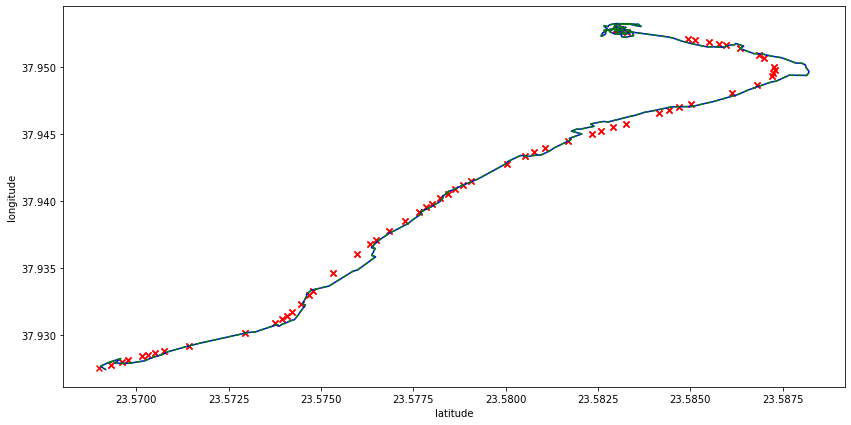

In [134]:
filenames = []
plt.figure(figsize=(14, 7))
#plt.scatter(x_temp, y_temp, s= store_weights*20)
#for n in range(1, len(expectation_x2[expectation_x2 !=0])):
plt.plot(expectation_x2[expectation_x2 !=0][1:], expectation_y2[expectation_y2 !=0][1:], 'b', label='PF mixture kernels')
plt.plot(expectation_x2[expectation_x2 !=0][1:], expectation_y2[expectation_y2 !=0][1:], 'g--', label='PTPF')
#plt.plot(expectation_x1[expectation_x1 !=0], expectation_y1[expectation_y1 !=0], 'b')
#plt.plot(expectation_x1[expectation_x1 !=0], expectation_y1[expectation_y1 !=0], 'g--', label='PTPF')
obs1x, obs1y = x_obs, y_obs
plt.scatter(obs1x[1:], obs1y[1:], marker='x', color='red',  label='observations')
#var = (np.linspace(0.0005, 0.005, len(expectation_x2[expectation_x2 !=0]))) / np.sqrt(np.sqrt(np.linspace(500,10000,len(expectation_x2[expectation_x2 !=0]))))
#var1 = (np.linspace(0.0005, 0.005, 189)) / np.sqrt(np.sqrt(np.linspace(500,10000,189)))
#plt.scatter(obs2x, obs2y , marker='x', color='red', label='observations traj 2')
#plt.fill_between(expectation_x2[expectation_x2 !=0][1:n],  expectation_y2[expectation_y2 !=0][1:n] - 1.96 * var[1:n],  expectation_y2[expectation_y2 !=0][1:n] + 1.96 * var[1:n], color='b', alpha=.01, label='CI')
#plt.fill_between(expectation_x1[expectation_x1 !=0][10:],  expectation_y1[expectation_y1 !=0][10:] - 1.96 * var1,  expectation_y1[expectation_y1 !=0][10:] + 1.96 * var1, color='b', alpha=.1)
    
    
#plt.xlim(23.577, 23.593)
#plt.ylim(37.90, 37.97)
#plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')

#filenames.append('plots_filter/' + str(n) +'.png')
#plt.savefig('plots_filter/' + str(n) +'.png')
#
#
#with imageio.get_writer('gif_filter2.gif', mode='I') as writer:
#    for filename in filenames:
#        image = imageio.imread(filename)
#        writer.append_data(image)
#
#from numpy import savetxt
#savetxt('real_data_both_x2.csv', expectation_x2, delimiter=',')
#savetxt('real_data_both_y2.csv', expectation_y2, delimiter=',')

In [135]:
obs2x, obs2y = df_vessel['lon'][0:-1:10], df_vessel['lat'][0:-1:10]


In [136]:
x1 = pd.read_csv('real_data_both_x.csv')
y1 = pd.read_csv('real_data_both_y.csv')

# Prediction step

In [142]:
def prediction_step(x_prec, current_t, delta_t, sigma_theta):
    sx_new, sy_new = [], []
    weights = []
    
    for x in x_prec:
        tau = x.get_tau() + ((current_t) * delta_t - x.get_tau())*np.random.uniform(0, 1)
     
        ax = np.random.normal(0, sigma_theta)
        ay = np.random.normal(0, sigma_theta)
        
        sx_new.append(get_space(x.get_sx(), x.get_vx(), x.get_ax(), x.get_tau(), tau))
        sy_new.append(get_space(x.get_sy(), x.get_vy(), x.get_ay(), x.get_tau(), tau))   
        
        weights.append(x.get_weight())

    weights = np.array(weights).reshape(1000, 1)
    
    return np.matmul(np.transpose(np.array(sx_new)), weights / np.sum(weights)), np.matmul(np.transpose(np.array(sy_new)), weights / np.sum(weights))

In [143]:
len(particles[:])

200

In [144]:
len(particles)

200

# Plots distribution of prediction 

Wall time: 3.52 s


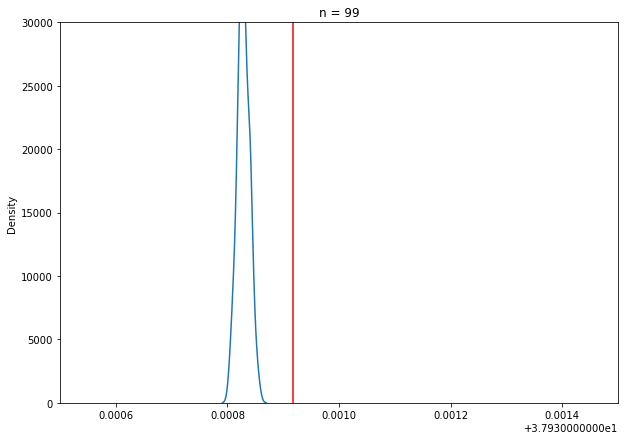

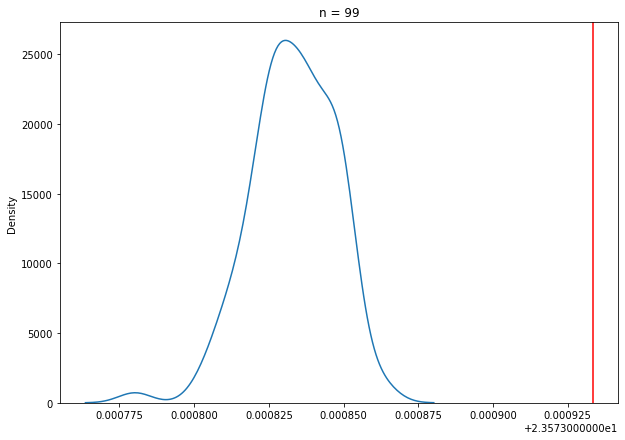

In [152]:
%%time
x_pred, y_pred = [], []
filenames = []
for i in range(100):
    x_pred_temp, y_pred_temp = prediction_step(particles[180], 180, delta_t, sigma_theta=0.5)
    x_pred.append(x_pred_temp[0][0])
    y_pred.append(y_pred_temp[0][0])
    
plt.figure(figsize=(10, 7))
sns.kdeplot(y_pred)
#plt.axvline(y_obs[179], color='red')
#plt.xlim(23.5735, 23.574)
plt.xlim(37.9305, 37.9315)
plt.ylim(0, 30000)
plt.title('n = ' + str(i))

plt.figure(figsize=(10, 7))
sns.kdeplot(x_pred)
#plt.axvline(x_obs[178], color='red')
#plt.xlim(23.5735, 23.574)
#plt.xlim(37.9305, 37.9315)
#plt.ylim(0, 30000)
plt.title('n = ' + str(i))
filenames.append('plots_predy/' + str(i) + '.png')
plt.savefig('plots_predy/'+ str(i)+'.png')
    
#with imageio.get_writer('gif_pred.gif', mode='I') as writer:
#    for filename in filenames:
#        image = imageio.imread(filename)
#        writer.append_data(image)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


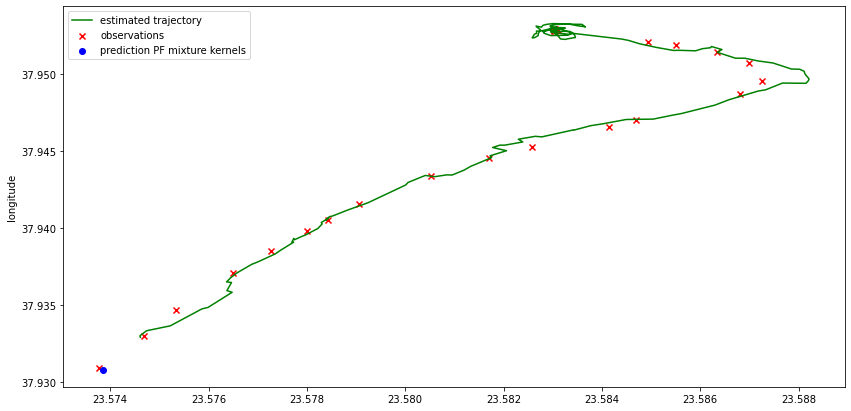

In [156]:
plt.figure(figsize=(14, 7))
#plt.scatter(x_temp, y_temp, s= store_weights*20)
plt.plot(expectation_x2[expectation_x2 != 0][0:170], expectation_y2[expectation_y2 !=0][0:170], 'g', label='estimated trajectory')
plt.scatter(x_obs[0:175:5], y_obs[0:175:5], marker='x', color='red', label='observations')
plt.scatter(x_obs[179], y_obs[179], marker='x', color='red', )
plt.scatter(x_pred_temp, y_pred_temp, marker='o', color='b', label='prediction PF mixture kernels')

plt.ylabel('longitude')
plt.legend()
plt.savefig('pred3.eps')

# PTPF

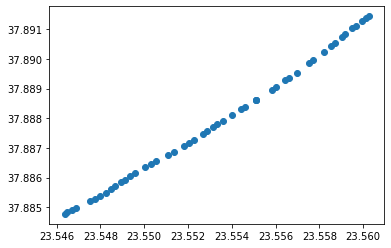

In [173]:
vessel_id = df['vessel_id'][2]
df_vessel = df[df['vessel_id'] == vessel_id].reset_index()

df_vessel['t'] = df_vessel['t'] - df_vessel['t'].min()

df_vessel = df_vessel.iloc[100:150].reset_index()

plt.scatter(df_vessel['lon'], df_vessel['lat'])

In [174]:
num_particles = 50000

T = len(df_vessel)
delta_t = 1
res = 1       #resolution for plotting hidden process

n_res = int(T / res)
n = int(T / delta_t)

sigma_theta = 0.00005
sigma_obs = 0.0002

gamma_shape = 0.7
gamma_scale = 1


s_x_0, s_y_0 = df_vessel['lon'][0], df_vessel['lat'][0]
v_x_0, v_y_0 = 0.0001, -0.0001

x_obs, y_obs = np.array(df_vessel['lon']), np.array(df_vessel['lat'])

x_obs = np.insert(x_obs, 0, s_x_0)
y_obs = np.insert(y_obs, 0, s_y_0)
lambda_0 = 50
delta_t_syn = delta_t * 2

gamma_shape = gamma_shape / 2
gamma_scale = gamma_scale / 2
b0 = 1
T_end = T
num_part = int(T_end / delta_t_syn)
num_obs_per_interval = int(delta_t_syn / delta_t)
print(num_obs_per_interval)
nodes_set = set()
V_act = []
V_end = []
prob_end = []
W_r0 = np.zeros(num_part + 1)
Gr_count = np.zeros(num_part + 1)
AS = False
        
keys = np.array(range(num_part + 1))
        
Fr = {k: [] for k in keys}
Fr_weights = {k: [] for k in keys}

2


In [175]:
len(x_obs)

51

In [176]:
seed = 11

In [177]:
def init_particles(s_x_0, s_y_0, v_x_0, v_y_0, sigma_theta, gamma_shape, gamma_scale, V_act, nodes_set, num_particles):
    for j in range(num_particles):
        sx, sy = s_x_0, s_y_0
        vx, vy = v_x_0, v_y_0
        ax, ay = np.random.normal(0, sigma_theta), np.random.normal(0, sigma_theta)  # this acceleration should not be needed 
        tau =  0
        particle = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None, 0, 0, 0, 0)
        V_act.append(particle)
        nodes_set.add(particle)
    return V_act, nodes_set 

In [178]:

V_act, nodes_set = init_particles(s_x_0, s_y_0, v_x_0, v_y_0, sigma_theta, gamma_shape, gamma_scale, V_act, nodes_set, num_particles)
V_init = V_act.copy()

while V_act:
    particle = V_act[0]
    
    if particle.get_parent() == None:
        Lambda = lambda_0
        particle.set_C(lambda_0)
        
    else:  # we now compute Lambda: in this case I call Lambda the intensity parameter multiplied my the weight
        
        if particle.get_in_F_r0() == 1:
            t_r = particle.get_t_r() 

            if (particle.get_W_ri() != 0.0) and (particle.get_W_ri() != 1.0):
                Lambda = (particle.get_W_ri() / W_r0[t_r]) * np.maximum(lambda_0 - Gr_count[t_r], b0) * 100
                #print(particle.get_W_ri(), W_r0[t_r], Gr_count[t_r], t_r)
                
                #Lambda = (0.1) * np.maximum(lambda_0 - Gr_count[t_r], b0) 
                #print(particle.get_W_ri() / W_r0[t_r], particle.get_W_ri(), W_r0[t_r])
                #Lambda = 1
            
            else :
                Lambda = 0
            #print(particle.get_W_ri(), W_r0[t_r], t_r, Lambda, particle.get_weight())

        else:
            
            Lambda = 1
        
        #if  (t_r > 0):
        #    if AS & (np.sum(Fr_weights[t_r - 1]) != 0):
        #        new_parent_index = choice(a = (np.array(range(len(Fr_weights[t_r - 1])))), size = 1, p = (Fr_weights[t_r - 1] / np.sum(Fr_weights[t_r - 1]) ))
    #
        #        new_parent = Fr[int(t_r - 1)][int(new_parent_index)]
        #        particle.set_parent(new_parent)
        # 
            
        parent = particle.get_parent()
        
        #particle.set_C(Lambda / particle.get_weight() * parent.get_C())
        #if particle.get_weight() != 0:
        #    particle.set_C((Lambda / particle.get_weight())* parent.get_C())
        #    print(particle.get_C())
        #else:
        #    particle.set_C(Lambda * parent.get_C())
    
    if (Lambda < 0) or (math.isnan(Lambda)):
        N = 0
    else:
        #print(Lambda)
        N = poisson(Lambda)
    
    if N > 0:
        for _ in range(N):
            tau = particle.get_tau() + np.random.gamma(shape=gamma_shape, scale=gamma_scale)
            
            t_r = int(tau // int(delta_t_syn))  #get last t_syn 
            if t_r > num_part:
                t_r = num_part
            ax, ay = normal(0, sigma_theta), normal(0, sigma_theta)
            #parent = particle.get_parent()
            #if parent == None:
            #    parent_tau = 0
            #else:
            #    parent_tau = particle.get_parent().get_tau()

            sx = get_space(particle.get_sx(), particle.get_vx(), ax, particle.get_tau(), tau)
            sy = get_space(particle.get_sy(), particle.get_vy(), ay, particle.get_tau(), tau)
            vx = get_velocity(particle.get_vx(), ax, particle.get_tau(), tau)
            vy = get_velocity(particle.get_vy(), ay, particle.get_tau(), tau)
            
            t_obs_prec = int(tau // int(delta_t))  #get index of last obs
            if t_obs_prec > n:
                t_obs_prec = n
            
            num_t_syn = t_r - particle.get_t_r()
            num_obs = t_obs_prec - particle.t_obs_prec
            likelihood = 1
            W_ri = 1
            
            # compute W_ri, W_r0 and G_r0 
            if num_t_syn > 0:
                if num_t_syn > 2:
              
                    for i in range(1, int(num_t_syn)):
                        Gr_count[int(t_r - i)] += 1
                        
                t_obs = (t_r - 1) * num_obs_per_interval
                
                for obs in range(num_obs_per_interval):
                    x_temp = get_space(sx, vx, ax, particle.get_tau(), t_obs * delta_t)
                    y_temp = get_space(sy, vy, ay, particle.get_tau(), t_obs * delta_t)
                    W_ri_temp = get_likelihood(x_temp, x_obs[int(t_obs)], y_temp, y_obs[int(t_obs)],sigma_obs)
                    #if W_ri_temp != 0.0:
                    W_ri *= W_ri_temp
                    t_obs += 1
                
                if W_ri != 1.0:
                    W_r0[int(t_r)] += W_ri
                    #print(W_r0[int(t_r)], W_ri, t_r)
                    in_F_r0 = 1
                else:
                    in_F_r0 = 0
               
            else:
                in_F_r0 = 0
                
            for i in range(int(particle.t_obs_prec) + 1, int(t_obs_prec + 1)):
                
                x_temp = get_space(sx, vx, ax, i*delta_t, particle.get_tau())
                y_temp = get_space(sy, vy, ay, i*delta_t, particle.get_tau())
                
                if i == int(particle.t_obs_prec) + 1:
                    likelihood_temp = get_likelihood(x_temp, x_obs[i], y_temp, y_obs[i], sigma_obs)
                    #if likelihood_temp != 0:
                    likelihood = likelihood_temp 
                else:
                    likelihood_temp =  get_likelihood(x_temp, x_obs[i], y_temp, y_obs[i], sigma_obs)
                    #if likelihood_temp != 0:
                    likelihood = likelihood * likelihood_temp
                        
            if (likelihood != 0) & (likelihood != 1):
                if in_F_r0 == 1:
                    child = Tree_Node (tau, [sx, sy], [vx, vy], [ax, ay], particle, likelihood, in_F_r0, t_r, t_obs_prec, W_ri)
                elif in_F_r0 == 0:
                    child = Tree_Node (tau, [sx, sy], [vx, vy], [ax, ay], particle, likelihood, in_F_r0, t_r, t_obs_prec)
            
                
                Fr[t_r].append(child)
                Fr_weights[t_r].append(child.get_weight())
                particle.add_child_node(child)
                
                if tau > T_end:
                    V_end.append(child)
                    prob_end.append(child.get_weight())# / particle.get_C())
                else:
                    V_act.append(child)
            
    V_act.remove(particle)

In [179]:
states_x, states_y = [], []
weights_obs_list = []

states_obs_time_x = np.zeros([len(V_end), n])
states_obs_time_y = np.zeros([len(V_end), n])

weights_obs = np.zeros([len(V_end), n])
exp_x = np.zeros(n)
exp_y = np.zeros(n) 


count = 0
for V in V_end:
    temp_x = np.zeros(n)
    temp_y = np.zeros(n)
    temp_w = np.zeros(n)
    
    current_node = V
    while current_node != None:
        parent = current_node.get_parent()
        
        if parent != None:
            t_obs = int(current_node.get_tau() // delta_t)
            t_obs_parent = int(parent.get_tau() // delta_t)
            
            if t_obs_parent > n:
                t_obs_parent = n
                
            if t_obs > n:
                t_obs = n
            
            #print(t_obs_parent + 1, t_obs + 1)
            for obs in range(t_obs_parent + 1, t_obs + 1):
                temp_x[obs - 1] = get_space(parent.get_sx(), parent.get_vx(), current_node.get_ax(), parent.get_tau(), obs*delta_t)
                temp_y[obs - 1] = get_space(parent.get_sy(), parent.get_vy(), current_node.get_ay(), parent.get_tau(), obs*delta_t)
                temp_w[obs - 1] = get_likelihood(temp_x[obs - 1], x_obs[obs - 1], temp_y[obs - 1], y_obs[obs - 1], sigma_obs)
                #print(temp_x[obs - 1], temp_y[obs - 1])
                
            #print(t_obs_parent + 1, t_obs + 1)
        
        current_node = parent
    states_obs_time_x[count, :] = temp_x
    states_obs_time_y[count, :] = temp_y
    weights_obs[count, :] = temp_w 
    
    count += 1
    
states_x.append(states_obs_time_x)
states_y.append(states_obs_time_y)
weights_obs_list.append(weights_obs)


for i in range(n):
     weights_obs[:, i] = weights_obs[:, i] / np.sum(weights_obs[:, i] )

for i in range(n):
    exp_x[i] = np.matmul(weights_obs[:, i], states_obs_time_x[:, i].transpose())
    exp_y[i] = np.matmul(weights_obs[:, i], states_obs_time_y[:, i].transpose())

Text(0, 0.5, 'y')

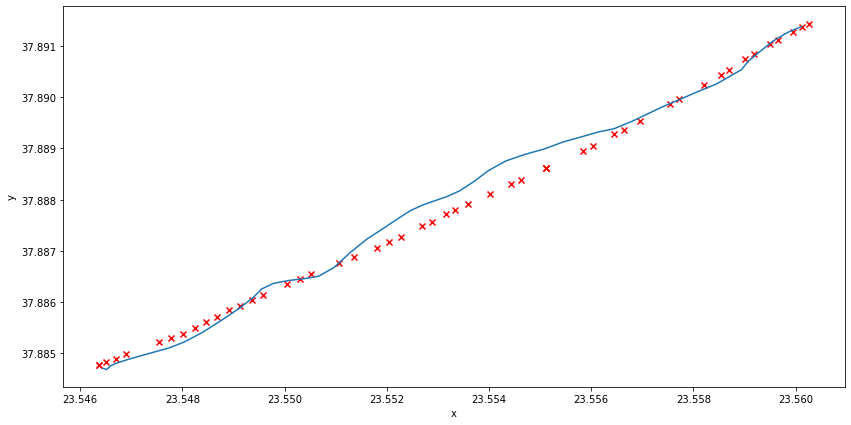

In [180]:
plt.figure(figsize=(14, 7))
plt.plot(exp_x, exp_y)
plt.scatter(x_obs, y_obs, marker='x', color='red')
plt.xlabel('x')
plt.ylabel('y')

# SMC^2

In [181]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import math
from importlib import reload
from scipy.io import savemat
import time

import matplotlib.pyplot as plt
import ParticleFilter
import Poisson_Tree_Particle_Filter

reload(ParticleFilter)
reload(Poisson_Tree_Particle_Filter)

from numpy.random import choice, poisson, gamma, normal
from scipy.stats import norm
from scipy.stats import bernoulli, gamma

In [182]:
df = pd.read_csv('unipi_ais_dynamic_sep2019.csv')

In [183]:
df = df.sort_values('t')
vessel_id = df['vessel_id'][2]

vessel_id = df['vessel_id'][2]
df_vessel = df[df['vessel_id'] == vessel_id].reset_index()

In [184]:
df_vessel['t'] = df_vessel['t'] - df_vessel['t'].min()

df_vessel = df_vessel.iloc[100:150].reset_index()

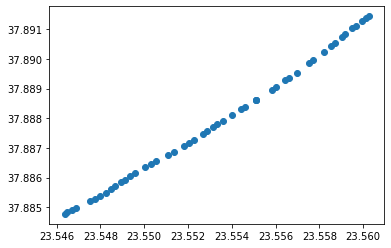

In [185]:
plt.scatter(df_vessel['lon'], df_vessel['lat'])

In [186]:
num_particles = 100
num_theta = 500

T = len(df_vessel)
delta_t = 1
n = int(T / delta_t)
sigma_theta = 0.0005
sigma_obs = 0.0005

gamma_shape = 0.100
gamma_scale = 0.25

lam = scipy.stats.gamma.cdf(delta_t, gamma_shape, scale=gamma_scale)
lam = T / (gamma_shape*gamma_scale*n)

s_x_0, s_y_0 = df_vessel['lon'][0], df_vessel['lat'][0]
v_x_0, v_y_0 = 0, 0

gamma_shape = gamma_shape 
gamma_scale = gamma_scale 

sigma_theta = sigma_theta 

x_obs, y_obs = np.array(df_vessel['lon']), np.array(df_vessel['lat'])

sigma_adjust = delta_t / 1000
capacity = n*3
weights = np.ones(num_particles)
log_weights = np.zeros(num_particles)
store_weights = np.zeros([num_particles, n + 2])

particles =  []

capacity = 500
expectation_x,  expectation_y = np.zeros(n + 2), np.zeros(n + 2)

num_unique_particles_pre = np.zeros(n + 2)
num_unique_particles_post = np.zeros(n + 2)
x_temp, y_temp = np.zeros([num_particles, n + 2]), np.zeros([num_particles, n + 2])
ess = np.zeros(n + 2)

In [187]:
def get_space(s_0, v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return s_0 + v_0 * dt + (1 / 2) * a_0 * (dt ** 2)

def get_velocity(v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return v_0 + a_0 * dt

def get_temporary_position(j, current_t, particles, delta_t):
    x_temp = get_space(particles[current_t][j].get_sx(), particles[current_t][j].get_vx(), particles[current_t][j].get_ax(), particles[current_t][j].get_tau(), current_t * delta_t)
    y_temp = get_space(particles[current_t][j].get_sy(), particles[current_t][j].get_vy(), particles[current_t][j].get_ay(), particles[current_t][j].get_tau(), current_t * delta_t)
    return x_temp, y_temp
    

def get_likelihood(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    pobsx_given_x, pobsy_given_y = norm.pdf(x_temp, x_obs, sigma_obs), norm.pdf(y_temp, y_obs, sigma_obs) 
    return pobsx_given_x * pobsy_given_y

def logLikelihood(x, mu, sigma):
    return - (1 / 2) * np.log(2*np.pi) - (1 / 2) * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * (x - mu)**2

def log_weights(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    loglikelihood_x = logLikelihood(x_temp, x_obs, sigma_obs)
    loglikelihood_y = logLikelihood(y_temp, y_obs, sigma_obs)
    return loglikelihood_x + loglikelihood_y
    
def init_particles(lam, num_particles, delta_t, particles, sigma_theta):
    for j in range(num_particles):
        sx, sy = s_x_0, s_y_0
        vx, vy = v_x_0, v_y_0
        ax, ay = np.random.normal(0, sigma_theta), np.random.normal(0, sigma_theta) 
        tau =  0
        particles[0].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None, 1))
    return particles


                        
def multiple_birth_move(current_t, j, particles, sigma_theta):
    k_new = 1
    #k_new = 2*np.ones(n)
    
    #ts = particles(j,tau,k(j)) + delta_t*rand(1,k_new(j));
  
    tau = particles[current_t - 1][j].get_tau() + ((current_t) * delta_t - particles[current_t - 1][j].get_tau())*np.random.uniform(0, 1, k_new)
 
    ax = np.random.normal(0, sigma_theta)
    ay = np.random.normal(0, sigma_theta)
    sx = get_space(particles[current_t - 1][j].get_sx(), particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    sy = get_space(particles[current_t - 1][j].get_sy(), particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau)
    vx = get_velocity(particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    vy = get_velocity(particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau) 

    particles[current_t].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 1][j]))
    particles[current_t - 1][j].add_child_node(particles[current_t][j])
    
    return particles
    
    
def resample(current_t, weights, num_particles):
    
    M = len(weights)
    
    ni = np.random.permutation(M)
    weights = weights[ni]
    
    inds = np.zeros(num_particles)
    
    weights = weights/np.sum(weights)
    cdf = np.cumsum(weights)
    
    cdf[-1] = 1
    
    p = np.linspace(np.random.uniform(0, 1) * (1 / num_particles), 1, num_particles)
    picked = np.zeros(M)
                    
    j=0
    for i in range(num_particles):
        while (j < M) & (cdf[j] < p[i]):
            j += 1
        picked[j] += 1
    
    rind = 0
    for i in range(M):
        if picked[i] > 0:
            for j in range(int(picked[i])):
                inds[rind] = int(ni[i])
                rind = rind + 1
                
    return inds.astype(int)

def adjust_move(current_t, j, particles, sigma_adjust):
    #new tau
    tau = -1
    while tau < 0:
        tau = np.random.normal(particles[current_t - 1][j].get_tau(), sigma_adjust)
    if tau <= 0:
        print(tau, j, t, 'adjust')
    #evaluate x and v in the new tau
    ax = particles[current_t - 1][j].get_ax()
    ay = particles[current_t - 1][j].get_ay()
    sx = get_space(particles[current_t - 1][j].get_sx(), particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    sy = get_space(particles[current_t - 1][j].get_sy(), particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau)
    vx = get_velocity(particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    vy = get_velocity(particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau) 

    
    if current_t == 1:
        particles[current_t - 1][j] = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None)
    else :
        particles[current_t - 1][j] = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 2][j])
    particles[current_t].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 1][j]))
    particles[current_t - 1][j].add_child_node(particles[current_t][j])
    
    return particles
                    

def compute_survivor_probability(current_t, num_particles, delta_t, particles, gamma_shape, gamma_scale):
    p = np.zeros(num_particles)
    
    for j in range(num_particles):
        p[j] = gamma.cdf(current_t* delta_t - particles[current_t - 1][j].get_tau(), gamma_shape, gamma_scale) - gamma.cdf(0, gamma_shape, gamma_scale)
            
        if  np.isnan(p[j]):
            print(p[j], current_t)
            print(gamma_shape, gamma_scale)

        
    S = np.ones(num_particles) - p
    
    return S
    
 

In [188]:
def PF_step(particles, weights, x_temp, y_temp, alpha, num_particles, S):
    particles.append([])
    
    for j in range(num_particles):
        
        if alpha[j] == 1:
            x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t-1, particles, delta_t)
        
            prev_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs) 
            
            particles = adjust_move(t, j, particles, sigma_adjust)
            x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t, particles, delta_t)
                                                                                                       
            curr_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
            
            #weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * S[j])
            weights[j] = curr_likelihood
            
            particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * S[j]))
            
            #if (prev_likelihood * S[j] != 0):
            #    weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * S[j])
            #else:
            #    weights[j] = (curr_likelihood * 1/2)
        
        else:
                
            x_temp[j, t],  y_temp[j, t] = get_temporary_position(j, t-1, particles, delta_t)
            
            prev_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
            
            particles = multiple_birth_move(t, j, particles, sigma_theta)
            x_temp[j, t],  y_temp[j, t] = get_temporary_position(j, t, particles, delta_t)
            
            curr_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
            
            weights[j] = curr_likelihood
            
            particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles[t - 1][j].get_tau()))))
            #weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles['tau'][j, k[j]-1])))

            #if (prev_likelihood * (1 - S[j]) != 0) and ((t+1) * delta_t - particles['tau'][j, k[j]-1] != 0):
            #    weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles['tau'][j, k[j]-1])))
            #else:
            #    weights[j] = curr_likelihood * 1 / 2
    #print(particles['tau'][:, k[9]])
    
    return particles, weights, x_temp, y_temp

In [189]:
def compute_Z(num_particles, stored_weights, t_final):
    return ((1 / num_particles) ** t_final) *  np.prod(np.sum(stored_weights, 0))

def get_mean_shape(num_theta, shape_weights, shape_values):
    return (1 / np.sum(shape_weights)) * np.matmul(shape_weights, shape_values)

def get_var_shape(num_theta, shape_weights, shape_values):
    return
    
def get_mean_scale(num_theta, scale_weights, scale_values):
    return (1 / np.sum(shape_weights)) * np.matmul(scale_weights, scale_values)

def get_var_scale(num_theta, scale_weights, scale_values):
    return 
    

def PMCMC_kernel(t_final, particles, stored_weights, gamma_shape_old, gamma_scale_old, lam, gamma_shape_mean, gamma_shape_variance, gamma_scale_mean, gamma_scale_variance, num_particles, delta_t, sigma_theta):
    gamma_shape_new =max(np.random.normal(gamma_shape_old, gamma_shape_variance / 2), 1)
    gamma_scale_new =max(np.random.normal(gamma_scale_old, gamma_scale_variance / 2), 1)
    
    particles_new = []
    weights_new = np.ones(num_particles)
    x_temp_new, y_temp_new = np.zeros([num_particles, t_final + 1]), np.zeros([num_particles, t_final + 1])
    store_weights_new = np.zeros([num_particles, t_final + 1])
    
    particles_new.append([])
    particles_new = init_particles(lam, num_particles, delta_t, particles_new, sigma_theta)

    for t in range(1, t_final + 1):
    
        if t == 1:
            alpha = np.zeros(num_particles)
            S = np.zeros(num_particles)
        else:
            S = compute_survivor_probability(t, num_particles, delta_t, particles_new, gamma_shape_new, gamma_scale_new)
            alpha = np.random.binomial(1, S, size = num_particles)
            
        particles_new, weights_new, x_temp_new, y_temp_new = PF_step(particles, weights_new, x_temp_new, y_temp_new, alpha, num_particles, S)
        store_weights_new[:, t] = weights_new
            
    Z_new = compute_Z(num_particles, store_weights_new, t_final)
    Z_old = compute_Z(num_particles, stored_weights, t_final)
    
    prior_scale_new, prior_scale_old = norm.pdf(gamma_scale_mean, gamma_scale_variance), norm.pdf(gamma_scale_mean, gamma_scale_variance)
    prior_shape_new, prior_shape_old = norm.pdf(gamma_shape_mean, gamma_shape_variance), norm.pdf(gamma_shape_mean, gamma_shape_variance)
    
    T_shape_new, T_shape_old = norm.pdf(gamma_scale_old, gamma_scale_variance / 2), norm.pdf(gamma_scale_new, gamma_scale_variance / 2)
    T_scale_new, T_scale_old = norm.pdf(gamma_shape_old, gamma_shape_variance / 2), norm.pdf(gamma_shape_new, gamma_shape_variance / 2)
    
    #print((prior_scale_new * Z_new *  T_scale_new) / (prior_scale_old * Z_old *  T_scale_old))
    #print((prior_shape_new * Z_new *  T_shape_new) / (prior_shape_old * Z_old *  T_shape_old))
    
    if  (prior_scale_old * Z_old *  T_scale_old) != 0:
        acc_prob_scale = min(1, (prior_scale_new * Z_new *  T_scale_new) / (prior_scale_old * Z_old *  T_scale_old))
    else:
        acc_prob_scale = 1
    if (prior_shape_old * Z_old *  T_shape_old) != 0:
        acc_prob_shape = min(1, (prior_shape_new * Z_new *  T_shape_new) / (prior_shape_old * Z_old *  T_shape_old))
    else:
        acc_prob_shape = 1
    
    U_shape, U_scale = np.random.uniform(), np.random.uniform()
    
    if U_shape < acc_prob_shape:
        gamma_shape_updated = gamma_shape_new
    else:
        gamma_shape_updated = gamma_shape_old
        
    if U_scale < acc_prob_scale:
        gamma_scale_updated = gamma_scale_new
    else:
        gamma_scale_updated = gamma_scale_old
        
    return gamma_shape_updated, gamma_scale_updated, particles_new, x_temp_new, y_temp_new, store_weights_new, weights_new

In [190]:
np.random.seed(11)

In [191]:
np.random.seed(11)

In [192]:
store_alpha = []
gamma_shape_mean = 0.100
gamma_scale_mean = 0.25

gamma_shape_variance = 1.0
gamma_scale_variance = 1.0

gamma_shape_list = []
gamma_shape_list = []

In [193]:
%%time

gamma_shape_values, gamma_scale_values = [], []

for N_t in range(num_theta):
    gamma_shape = max(np.random.normal(gamma_shape_mean, gamma_shape_variance), 1)
    gamma_scale = max(np.random.normal(gamma_scale_mean, gamma_scale_variance), 1)
    particles.append([])
    particles[N_t].append([])
    particles[N_t] = init_particles(lam, num_particles, delta_t, particles[N_t], sigma_theta)
    for t in range(1, n):
        
        if t == 1:
            alpha = np.zeros(num_particles)
            S = np.zeros(num_particles)
        else:
            S = compute_survivor_probability(t, num_particles, delta_t, particles[N_t], gamma_shape, gamma_scale)
            alpha = np.random.binomial(1, S, size = num_particles)
            
        particles[N_t], weights, x_temp, y_temp = PF_step(particles[N_t], weights, x_temp, y_temp, alpha, num_particles, S)
        
        #print(weights)
        store_weights[:, t] = weights 
            
        expectation_x[t] = np.matmul(weights / np.sum(weights), x_temp[:, t])
        expectation_y[t] = np.matmul(weights / np.sum(weights), y_temp[:, t])
        
        if np.sum(weights**2) != 0:
            ess[t] = (np.sum(weights))**2 / np.sum(weights**2)
            if (ess[t] < 0.5*num_particles) & (t < n) :         
                gamma_shape, gamma_scale, particles[N_t], x_temp[:, 0 : t + 1], y_temp[:, 0 : t + 1], store_weights[:, 0 : t + 1], weights = PMCMC_kernel(t, particles[N_t], store_weights, gamma_shape, gamma_scale, lam, gamma_shape_mean, gamma_shape_variance, gamma_scale_mean, gamma_scale_variance, num_particles, delta_t, sigma_theta)
                
        expectation_x[t] = np.matmul(weights / np.sum(weights), x_temp[:, t])
        expectation_y[t] = np.matmul(weights / np.sum(weights), y_temp[:, t])
        
        gamma_shape_values.append(gamma_shape)
        gamma_scale_values.append(gamma_scale)
                

C:\Users\Chiara\AppData\Local\Temp/ipykernel_9756/3674215956.py:19: RuntimeWarning: invalid value encountered in double_scalars
  particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * S[j]))
C:\Users\Chiara\AppData\Local\Temp/ipykernel_9756/3674215956.py:39: RuntimeWarning: invalid value encountered in true_divide
  particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles[t - 1][j].get_tau()))))
C:\Users\Chiara\AppData\Local\Temp/ipykernel_9756/3674215956.py:39: RuntimeWarning: divide by zero encountered in true_divide
  particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles[t - 1][j].get_tau()))))
C:\Users\Chiara\AppData\Local\Temp/ipykernel_9756/3674215956.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  particles[t][j].set_weight((curr_likelihood * 1/2) / (prev_likelihood * S[j]))
<timed exec>:23: RuntimeWarning: invalid val

Wall time: 5min 52s


In [194]:
delta_taus = []

for i in range(num_theta):
    for part in particles[i][41]:
        while part != None:
            tau = part.get_tau()
            parent = part.get_parent()
            if parent != None:
                tau_parent = parent.get_tau()
                delta_taus.append(int(tau - tau_parent))
            part = parent


In [197]:
import scipy.stats as stats
from matplotlib.pyplot import figure 

figure(figsize=(10, 6))
sns.kdeplot(np.array(delta_taus)[np.array(delta_taus) >0] + 15, label = 'estimated distribution of inter arrival times, PF MK SMC$^2$')
x = np.linspace (0, 150, 150) 

#calculate pdf of Gamma distribution for each x-value
y = stats.gamma.pdf(x, a=10, scale=2.5)

#create plot of Gamma distribution
#plt.plot(x, y, '--', label='pdf Gammma - shape=10, scale=2.5')
plt.legend()
#display plot
plt.show()